In [210]:
import torch
import pprint as pp
import torchvision
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
import numpy as np
from operator import add
import matplotlib.pyplot as plt
from tqdm import tqdm

In [211]:
# hyperparameters

batch_size = 64
num_caps = 16
learning_rate = 0.01
weight_decay = 1e-5
momentum = 0.5
torch.backends.cudnn.enabled = False

In [212]:
# Create data loaders.

transform = torchvision.transforms.Compose([
              torchvision.transforms.ToTensor(),
            ])
train_dataloader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=transform),
  batch_size=batch_size, shuffle=True, drop_last=True)

test_dataloader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=transform),
  batch_size=batch_size, shuffle=True, drop_last=True)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


In [213]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


$$
W_{30\times20} \times g(W_{20\times10} \times x_{10}) 
\neq (W_{30\times20} \times W_{20\times10}) \times x_{10} 
= W_{30\times 10} \times x_{10}
$$

In [180]:
def shift_image(image):
    dx = np.random.randint(-3, 4)
    dy = np.random.randint(-3, 4)
    image = torch.roll(image, dx, -1)
    image = torch.roll(image, dy, -2)
    return image, dx, dy

shifts = [
          [-2, -2], [-2, -1], [-2, 0], [-2, 1], [-2, 2],
          [-1, -2], [-1, -1], [-1, 0], [-1, 1], [-1, 2],
          [0, -2], [0, -1], [0, 0], [0, 1], [0, 2],
          [1, -2], [1, -1], [1, 0], [1, 1], [1, 2],
          [2, -2], [2, -1], [2, 0], [2, 1], [2, 2]
         ]

In [214]:
class Capsule(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            # N, 1, 28, 28
            nn.Conv2d(1, 16, 3, padding=1, bias=False),
            nn.BatchNorm2d(16), 
            nn.ReLU(True),
            nn.MaxPool2d(2), # 14
            
            nn.Conv2d(16, 8, 3, padding=1, bias=False),
            nn.BatchNorm2d(8), 
            nn.ReLU(True),
            nn.MaxPool2d(2), # 7
        )
    
        self.lin = nn.Sequential(
            nn.Linear(8, 3),
        )

        self.decoder_lin = nn.Sequential(
            nn.Linear(2, 4*49), 
        )

        self.decoder = nn.Sequential(
            nn.ReLU(True),
            nn.ConvTranspose2d(4, 32, 3, stride=2, padding=1, bias=False, output_padding=1), # B, 8, 14, 14
            nn.BatchNorm2d(32), 
            nn.ReLU(True),

            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, bias=True, output_padding=1), # B, 1, 28, 28  
            nn.Sigmoid()
        )

        self.sig = nn.Sigmoid()

    def encode(self, x):
        x = self.encoder(x)
        x = x.mean(-1).mean(-1)
        z = self.lin(x)
        p = z[:,[0]]
        p = self.sig(p)
        x = z[:,[1]]
        y = z[:,[2]]
        return p, x, y
    
    
    def decode(self, xy):
        xy = self.decoder_lin(xy)
        xy = torch.reshape(xy, (64, 4 ,7 , 7))
        return self.decoder(xy)
    
capsule = Capsule().to(device)

In [215]:
class TAE(nn.Module):
    def __init__(self, num_caps=num_caps):
        super().__init__()
        self.caps = nn.ModuleList([
            Capsule().to(device) for _ in range(num_caps) 
        ])
    
    def forward(self, img, img_shifted, dx, dy):
        img_reconstructed = 0.0
        img_shifted_reconstructed = 0.0     
        loss_coordinates = 0.0 
        loss_reconstructed = 0.0

        for caps in self.caps:
            p, x, y = caps.encode(img)
            p_shifted, x_shift, y_shift = caps.encode(img_shifted)

            # Reconstruct original image
            xy = torch.hstack((x, y))
            img_reconstructed = img_reconstructed + caps.decode(xy) * p[:,:,None,None]
            
            # Reconstruct shifted image
            xy_shifted = xy + torch.Tensor([dx, dy]).to(device)
            img_shifted_reconstructed = img_shifted_reconstructed + caps.decode(xy_shifted) * p_shifted[:,:,None,None]

            # Sum the loss of coordinates from both original and shifted image
            loss_coordinates = (((x_shift - x) - dx).pow(2) * p[:,:,None,None]).sum()
            loss_coordinates += (((y_shift - y) - dy).pow(2) * p[:,:,None,None]).sum()

        # Sum up the MSE losses of the reconstructed orignal and reconstructed shifted image
        loss_reconstructed += ((img_reconstructed - img).pow(2).mean() + (img_shifted_reconstructed - img_shifted).pow(2).mean())

        return loss_coordinates, loss_reconstructed, img_shifted_reconstructed
    
    

model = TAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [216]:
def train(train_loader):
    model.train()
    loss = 0
    criterion = nn.MSELoss().to(device)
    
    for batch_features, target in train_loader:
        # if i % 100 == 0:
        #     print(i)

        batch_features, target = batch_features.to(device), target.to(device)       
        new_features, dx, dy = shift_image(batch_features)

        optimizer.zero_grad()
        
        loss_coordinates, loss_reconstructed, output_image = model(batch_features, new_features, dx, dy)
        #shifted_p, shifted_image_reconstructed = model(new_features)

        # [(p1_1, (x1_1, y1_1)), (p1_2, (x1_2, y1_2)), ...] = model.encode(batch_features)
        # [(p1_1, (x1_1, y1_1)), (p1_2, (x1_2, y1_2)), ...] = model.encode(new_features)

        # loss_coordinates = (x2_1 - x1_1 - dx).pow(2) * p1_1
        # loss_coordinates += (x2_2 - x1_2 - dx).pow(2) * p1_2
        # loss_coordinates += (y2_2 - y1_2 - dy).pow(2) * p1_2
        # loss_coordinates += (y2_2 - y1_2 - dy).pow(2) * p1_2

        # img_1_reconstructed = model.decode([(p1_1, (x1_1, y1_1)), (p1_2, (x1_2, y1_2)), ...])
        # img_2_reconstructed = model.decode([(p1_1, (x1_1, y1_1)), (p1_2, (x1_2, y1_2)), ...])
        # loss_reconstructed = (rec_image - batch_features).pow(2).mean() + (img_2_reconstructed - new_features).pow(2).mean()
        train_loss = 5 * loss_coordinates + loss_reconstructed
        
        #output_image = model(batch_features, torch.Tensor([dx, dy]).to(device))

        # compute training reconstruction loss
        #train_loss = criterion(output_image, new_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss = loss + train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(train_loader)
    
    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f}".format(epochs + 1, epochs, loss))
    return output_image, new_features

def test(test_loader):
    model.eval()
    outputs = []
    for batch_features, target in test_loader:
        batch_features, target = batch_features.to(device), target.to(device)

        for dx, dy in shifts:
            rolled_image = torch.roll(batch_features, dx, -1)
            rolled_image = torch.roll(rolled_image, dy, -2)
            new_features, dx, dy = shift_image(rolled_image)
            _, _, output_image = model(batch_features, new_features, dx, dy)
            #output_image = model(batch_features, torch.Tensor([dx, dy]).to(device))
            outputs.append(output_image)

        return outputs, target[0]

In [ ]:
torch.autograd.set_detect_anomaly(True)

epochs = 8
outputs = []  
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    output, _ = train(train_dataloader)
    outputs.append(output)
shift_grid = test(test_dataloader)

print("Finished")

Epoch 1
-------------------------------


In [206]:
# for k in range(0, epochs, 4): 
#     plt.figure(figsize=(9, 2))
#     plt.gray()
#     imgs = outputs[k].detach().cpu().numpy()
#     for i, item in enumerate(imgs):
#         if i >= 9: break
#         plt.subplot(2,9, i+1)
#         plt.imshow(item[0])

#     for i, item in enumerate(recon):
#         if i >= 9: break
#         plt.subplot(2, 9, 9+i+1)
#         plt.imshow(item)

shift_grid = test(test_dataloader)

tensor(5, device='cuda:0')
tensor(0, device='cuda:0')
tensor(7, device='cuda:0')
tensor(1, device='cuda:0')
tensor(2, device='cuda:0')


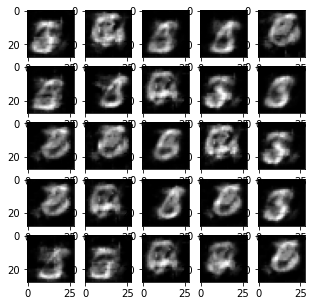

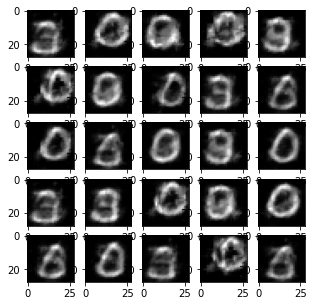

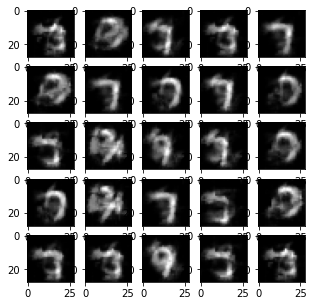

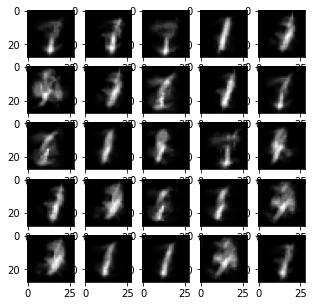

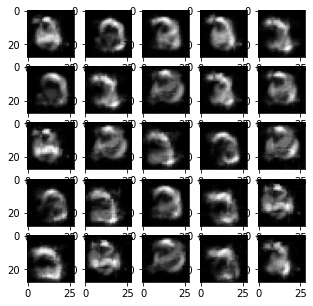

In [207]:
for _ in range(5):
    shift_grid, target = test(test_dataloader)
    print(target)
    plt.figure(figsize=(5, 5))
    plt.gray()
    for i, item in enumerate(shift_grid):
        item = item.detach().cpu().numpy()
        if i >= 25: break
        plt.subplot(5,5, i+1)
        plt.imshow(item[0][0])


In [76]:
x =  torch.zeros([64, 1])
y =  torch.ones([64, 1])
(torch.hstack((x,y))).size()

torch.Size([64, 2])